In [265]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pickle

import utils as u
from models import Matern12_Model, Poisson_Model_T, SafeMatern32_Model, ST_Model, All_Matern_Model, Poisson_Model
import seaborn as sns
%matplotlib inline


sns.set()
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 100


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [284]:
data = pd.read_csv('../data/gp_cut_weekly_grid_parkslope.csv')
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data.DATE_IND = data.DATE_IND / 100
data.x_point = data.x_point / 100
data.y_point = data.y_point / 100

mean_e = data.groupby('DATETIME')['COUNT'].sum().loc['2015-01-01':'2015-12-31'].mean()

e_s = ((mean_e) / data.GRID_SQUARE.max()) # 5.36 is 2016 mean weekly crashes in park slope, divide by # squares
print(e_s)

0.615384615385


In [285]:
search_periods = [[4,12],
                  [6,12]]

Beginning run [4, 12] : 
Training ends on: 2017-04-30 00:00:00
testing ends on: 2017-07-23 00:00:00
Initial neg. log-likelihood: -1063.522049
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 225.937712
  Number of iterations: 607
  Number of functions evaluations: 663
added gp pred and error to test
gp_sq_error      2.420732
0              412.367886
dtype: float64
Beginning run [6, 12] : 
Training ends on: 2017-05-14 00:00:00
testing ends on: 2017-08-06 00:00:00
Initial neg. log-likelihood: -1496.14279985
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 303.472694
  Number of iterations: 603
  Number of functions evaluations: 658
added gp pred and error to test
gp_sq_error    1.27439
0              3.45935
dtype: float64


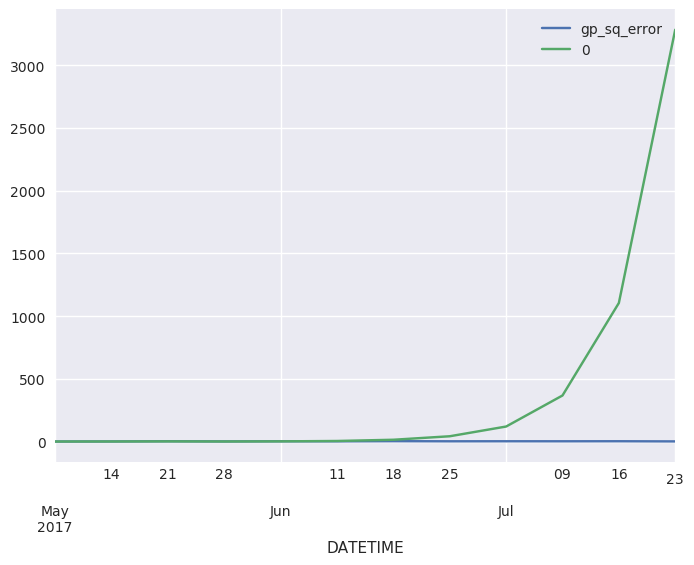

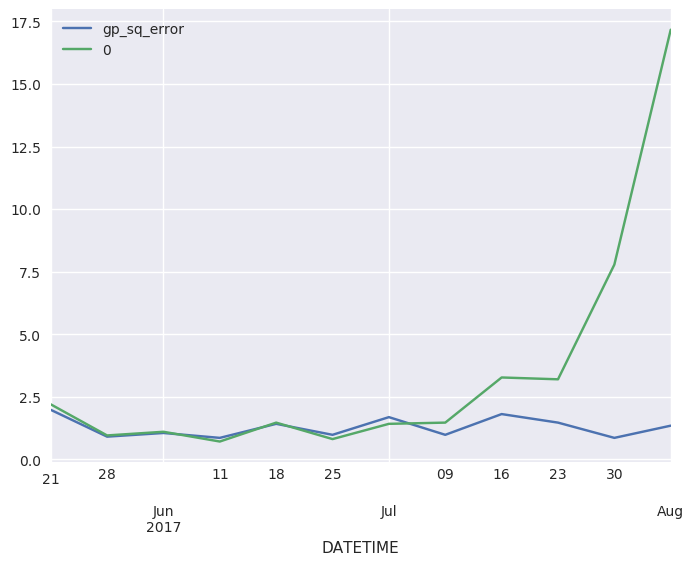

In [286]:
for i, s in enumerate(search_periods):
    
    print('Beginning run {} : '.format(str(s)))
    #print('{} periods for training \n').format(s[0])
    #print('{} periods for testing \n').format(s[1])

    data_dict = u.preprocess(data, start_date= '2017/4/02', training_end_date= s[0], \
                                                           testing_end_date=s[1])

    m = Poisson_Model_T(data_dict['X_train'],data_dict['y_train'],use_priors=True, e_s= e_s, period = 1)
    m.compile()
    opt = gpflow.train.ScipyOptimizer()
    print('Initial neg. log-likelihood: {}'.format(str(m.compute_log_likelihood())))
    opt.minimize(m, maxiter = 1000)
    
    u.pred_GP(m,data_dict)
    
    test = data_dict['test']

    gp = test.groupby('DATETIME')['gp_sq_error'].mean() #/ test.GRID_SQUARE.max()
    ar = u.run_AR(data_dict)
    summary = pd.concat([gp,ar],axis=1)
    summary.plot()

    print(summary.mean())


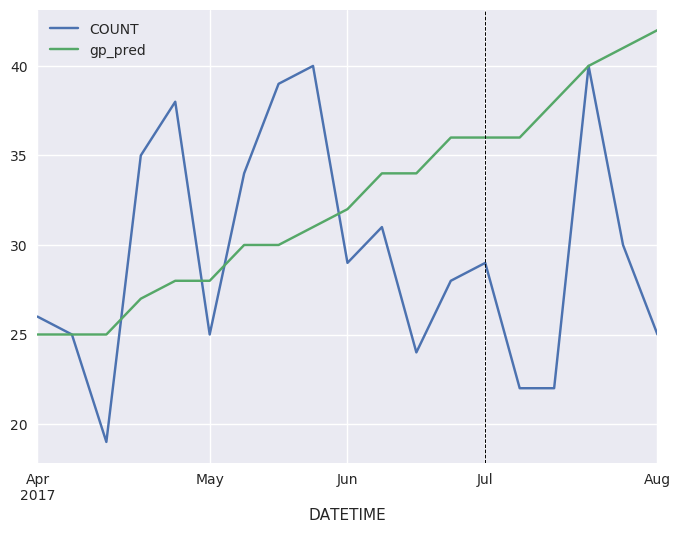

In [287]:
pred_train = m.predict_y(data_dict['X_train'])
pred_test = m.predict_y(data_dict['X_test'])

train['f_pred'] = m.predict_f(data_dict['X_train'])[0]
test['f_pred'] = m.predict_f(data_dict['X_test'])[0]

train = data_dict['train']
train['gp_pred'] = np.round(pred_train[0],0)
train['gp_var'] = pred_train[1]
train['gp_error'] = train.gp_pred - train.COUNT
train['gp_sq_error'] = np.square(train.gp_error)



test = data_dict['test']
test['gp_pred'] = np.round(pred_test[0],0)
test['gp_var'] = pred_test[1]


pred = train.append(test)#[['COUNT','gp_pred']]
pred['exp_f_pred'] = np.exp(pred.f_pred)

pred.groupby('DATETIME')[['COUNT','gp_pred']].sum().plot()
plt.axvline('2017-07-02', linestyle='--', color = 'black', linewidth = 0.7)


In [293]:
pred.groupby('GRID_SQUARE')['exp_f_pred'].mean().to_csv('files/grid_square_f_scores.csv')

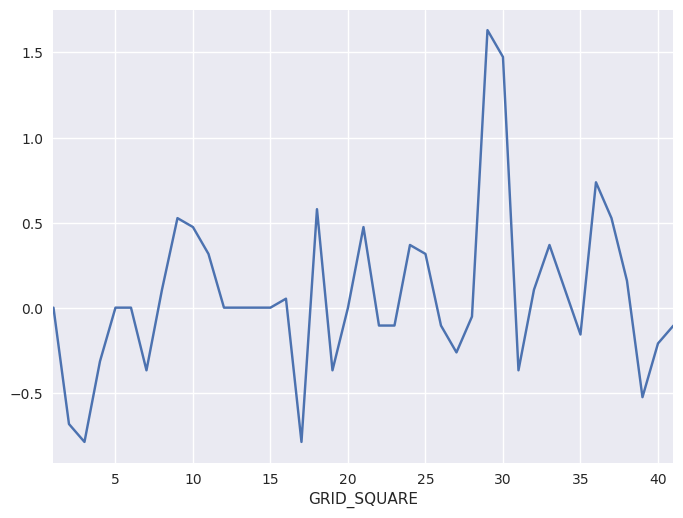

In [289]:
pred.groupby('GRID_SQUARE').mean()['gp_error'].plot()#.sort_values(ascending = False)

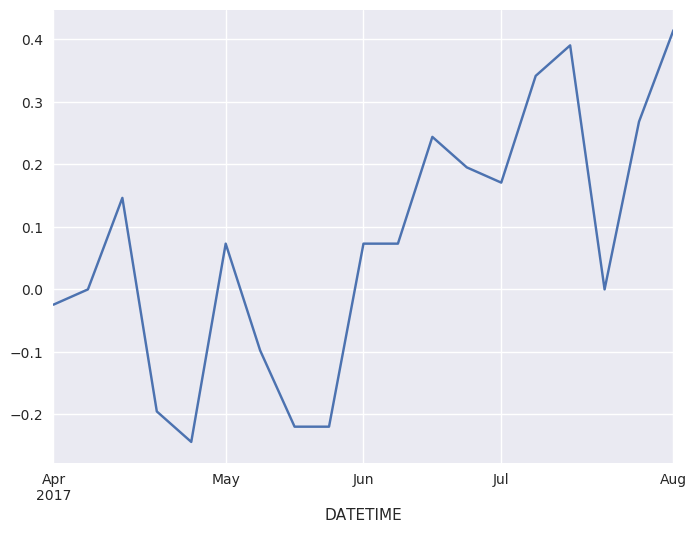

In [290]:
pred.groupby('DATETIME').mean()['gp_error'].plot()#.sort_values(ascending = False)

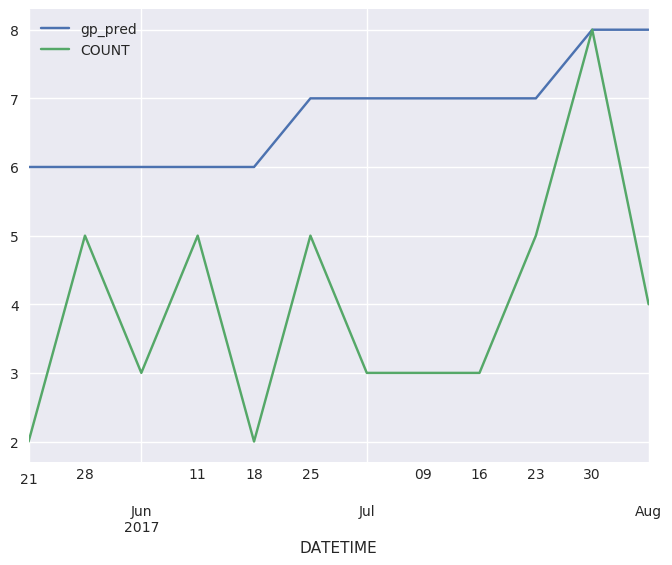

In [291]:
test[test.GRID_SQUARE == 29][['gp_pred','COUNT']].plot()

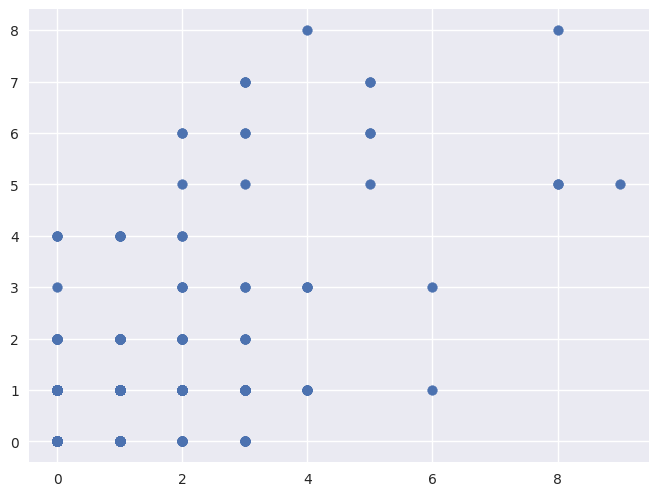

In [292]:
plt.scatter(x = pred.COUNT, y = pred.gp_pred)